In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import string
import nltk
import numpy as np
import joblib
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle


In [37]:
df = pd.read_csv('spambalance.csv')
print(df.head())
# Check basic info and head of the dataset
df.info()
df.head()


  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8483 entries, 0 to 8482
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  8483 non-null   object
 1   Message   8483 non-null   object
dtypes: object(2)
memory usage: 132.7+ KB


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Analysis Results:
Total number of emails: 8483
Number of spam emails: 3655 (43.09%)
Number of ham emails: 4828 (56.91%)


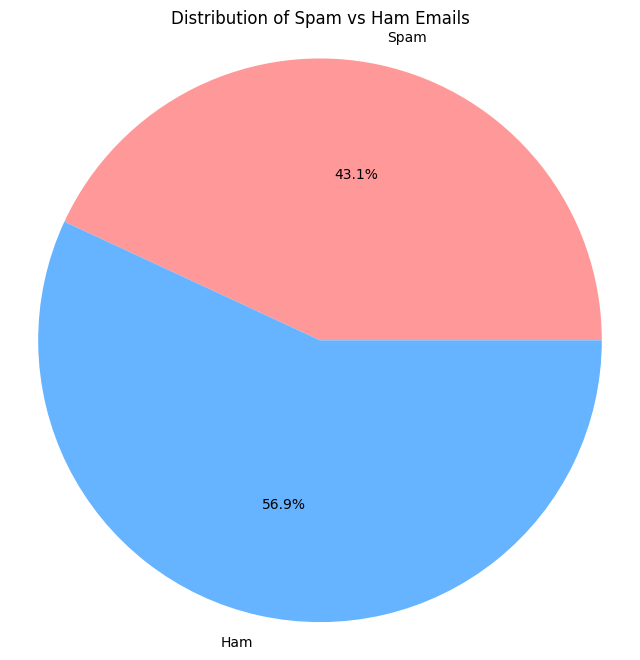

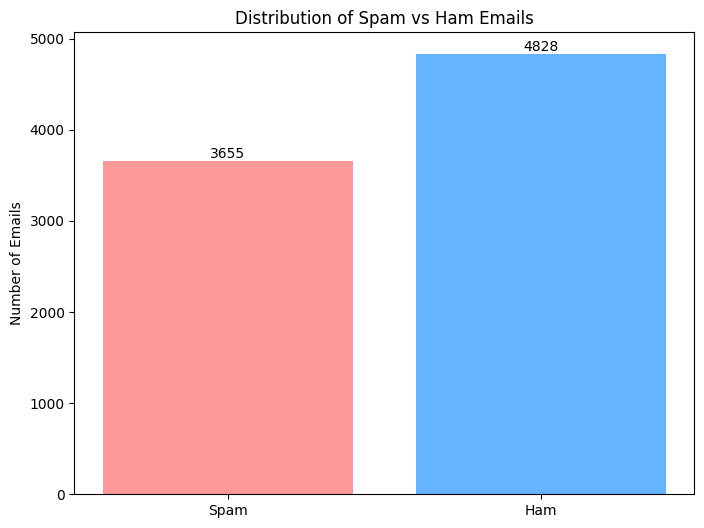

In [39]:
total_emails = len(df)
spam_count = df[df['Category'] == 'spam'].shape[0]  # Assuming 'Category' column contains 'spam' and 'ham'
ham_count = df[df['Category'] == 'ham'].shape[0]

# Calculate percentages
spam_percentage = (spam_count / total_emails) * 100
ham_percentage = (ham_count / total_emails) * 100

# Print the analysis results
print("\nAnalysis Results:")
print(f"Total number of emails: {total_emails}")
print(f"Number of spam emails: {spam_count} ({spam_percentage:.2f}%)")
print(f"Number of ham emails: {ham_count} ({ham_percentage:.2f}%)")

# Create Pie Chart for visualization
plt.figure(figsize=(8, 8))
plt.pie([spam_count, ham_count], 
        labels=['Spam', 'Ham'],
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'])
plt.title('Distribution of Spam vs Ham Emails')
plt.axis('equal')
plt.show()

# Create Bar Plot for visualization
plt.figure(figsize=(8, 6))
plt.bar(['Spam', 'Ham'], [spam_count, ham_count], 
        color=['#ff9999', '#66b3ff'])
plt.title('Distribution of Spam vs Ham Emails')
plt.ylabel('Number of Emails')
for i, count in enumerate([spam_count, ham_count]):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

In [40]:
# Define text cleanup function
nltk.download('stopwords')
nltk.download('wordnet')

def text_cleanup(text):
    """Clean and preprocess text data."""
    if not isinstance(text, str):
        return []

    # Remove punctuation
    text_without_punctuation = ''.join([c for c in text if c not in string.punctuation])

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in text_without_punctuation.split() if word.lower() not in stop_words]

    return words

# Sample cleanup for one email
sample_email = df['Message'][0]
cleaned_sample = text_cleanup(sample_email)
print(f"Cleaned Sample Email: {cleaned_sample}")


Cleaned Sample Email: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
def extract_features(df, text_column='Message'):
    """Extract word features from email text."""
    lmtzr = WordNetLemmatizer()
    word_counts = {}

    print(f"Processing {len(df)} emails...")
    for text in df[text_column]:
        words = text_cleanup(text)
        for word in words:
            if not word.isdigit() and len(word) > 2:
                word = lmtzr.lemmatize(word)
                word_counts[word] = word_counts.get(word, 0) + 1

    # Filter words that appear at least 100 times
    frequent_words = {word: count for word, count in word_counts.items() if count >= 100}
    word_features = list(frequent_words.keys())
    
    print(f"Total unique words: {len(word_counts)}")
    print(f"Filtered words (≥ 100 occurrences): {len(word_features)}")
    
    # Save the list of word features
    joblib.dump(word_features, 'word_features.pkl')
    print("Word feature list saved to 'word_features.pkl'")
    return word_features

# Extract word features and save them
word_features = extract_features(df)


Processing 8483 emails...
Total unique words: 9841
Filtered words (≥ 100 occurrences): 171
Word feature list saved to 'word_features.pkl'


In [42]:
def process_email_to_features(email_text, word_features):
    """Convert email text into a feature vector based on word frequencies."""
    cleaned_words = text_cleanup(email_text)
    lmtzr = WordNetLemmatizer()

    email_word_count = {}
    for word in cleaned_words:
        if not word.isdigit() and len(word) > 2:
            word = lmtzr.lemmatize(word)
            email_word_count[word] = email_word_count.get(word, 0) + 1

    # Convert to feature vector
    feature_vector = [email_word_count.get(word, 0) for word in word_features]
    
    return feature_vector

# Example of converting the first email into a feature vector
first_email_features = process_email_to_features(df['Message'][0], word_features)
print(f"Feature Vector for First Email: {first_email_features[:10]}")  # Display first 10 features


Feature Vector for First Email: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [43]:
# Convert all emails to feature vectors
feature_matrix = np.array([process_email_to_features(text, word_features) for text in df['Message']])

# Convert labels (ham/spam) into numerical values
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

# Labels (target variable)
labels = df['Category'].values

# Save preprocessed data
preprocessed_data = {'features': feature_matrix, 'labels': labels}
with open("email_features.pkl", 'wb') as f:
    pickle.dump(preprocessed_data, f)
    
print("Preprocessed feature data saved to 'email_features.pkl'")


Preprocessed feature data saved to 'email_features.pkl'


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the preprocessed data
with open("email_features.pkl", 'rb') as f:
    data = pickle.load(f)
feature_matrix = data['features']
labels = data['labels']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save Random Forest model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)




Accuracy: 0.9760
Precision: 0.9806
Recall: 0.9636
F1 Score: 0.9720


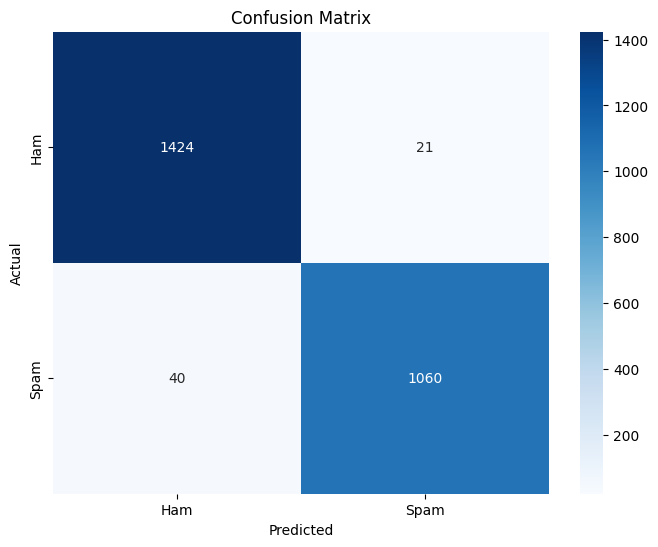

Confusion Matrix:
[[1424   21]
 [  40 1060]]


In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the test set and trained Random Forest model
# X_test: features of the test set
# y_test: true labels of the test set (ground truth)
# rf_model: trained RandomForest model

# Step 1: Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Optionally, you can print out the confusion matrix as well
print("Confusion Matrix:")
print(cm)


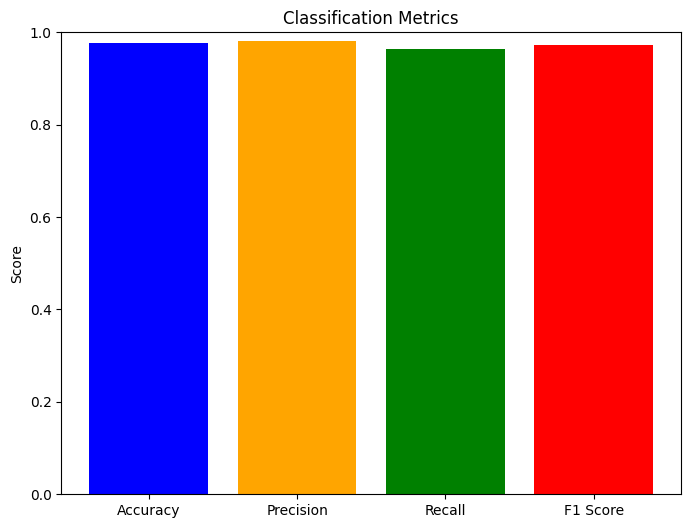

In [47]:
import matplotlib.pyplot as plt

# Sample data (replace with your own metric values)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]  # These should be calculated metrics

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Values are between 0 and 1 for accuracy, precision, recall, and F1-score
plt.show()


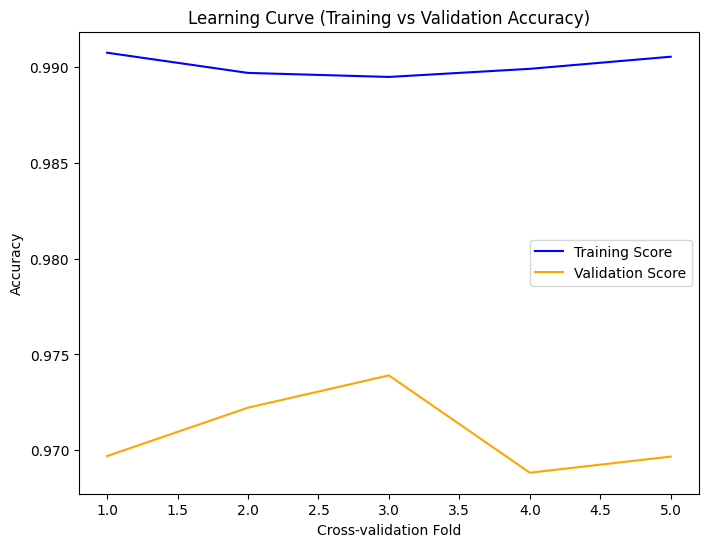

Average Training Accuracy: 0.99
Average Validation Accuracy: 0.97


In [48]:
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt

# Assuming your RandomForestClassifier is already defined as rf_model
from sklearn.ensemble import RandomForestClassifier

# Example data: X_train, y_train are your features and labels respectively
# Replace these with your actual dataset
# X_train, y_train = ...

# Perform cross-validation
cv_results = cross_validate(rf_model, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True)

# Extract the training and validation scores (cross-validation scores)
train_scores = cv_results['train_score']
val_scores = cv_results['test_score']  # These are the validation scores

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label='Training Score', color='blue')
plt.plot(range(1, len(val_scores) + 1), val_scores, label='Validation Score', color='orange')
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Cross-validation Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Optionally, you can calculate the mean score of the cross-validation results
print(f"Average Training Accuracy: {train_scores.mean():.2f}")
print(f"Average Validation Accuracy: {val_scores.mean():.2f}")


In [45]:
def predict_email(email_text, model, word_features):
    """Predict whether an email is spam or ham."""
    features = process_email_to_features(email_text, word_features)
    prediction = model.predict([features])[0]
    probability = model.predict_proba([features])[0]
    
    return prediction, probability

# Load the trained model and word features
model = joblib.load('spam_classifier_rf.pkl')
word_features = joblib.load('word_features.pkl')

# Test with some sample emails
test_emails = [
    "Win a free iPhone now! Click this link.",
    "Meeting schedule for tomorrow at 10 AM.",
    "Congratulations! You've won a $1000 gift card.",
    "Can you review the attached document?"
]

for email in test_emails:
    prediction, probability = predict_email(email, model, word_features)
    result = "SPAM" if prediction == 1 else "HAM"
    print(f"Email: {email}\nPrediction: {result}, Spam Probability: {probability[1]:.2f}\n")


Email: Win a free iPhone now! Click this link.
Prediction: SPAM, Spam Probability: 0.98

Email: Meeting schedule for tomorrow at 10 AM.
Prediction: HAM, Spam Probability: 0.02

Email: Congratulations! You've won a $1000 gift card.
Prediction: HAM, Spam Probability: 0.33

Email: Can you review the attached document?
Prediction: HAM, Spam Probability: 0.02

